## Imports and Definitions

In [25]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

import glob

import scipy as sp

In [3]:
hetvips_lamost = Table.read('hetvips_lamost.fits', format = 'fits')

In [4]:
# creating wavelength grid
wave_len = len(hetvips_lamost['spec'][0])
wave_arr = np.linspace(3470,5540,wave_len)
print(wave_len,len(wave_arr))

1036 1036


In [5]:
hetvips_lamost

objID_1,RA,Dec,shotid,gmag,rmag,imag,zmag,ymag,sn,barycor,mjd,exptime,chi2_star,chi2_galaxy,chi2_qso,z_star,z_galaxy,z_qso,z_best,classification,stellartype,ObjID_2,filename_1,index_in_file,spec,spec_error,spec_weight,RV_1,barycorr,SPECID_1,RA_1,DEC_1,SNR_U,SNR_G,SNR_R,SNR_I,SNR_Z,RV_2,RV_ERR,TEFF,TEFF_ERR,TEFF_FLAG,TEFF_GRADCORR,LOGG,LOGG_ERR,LOGG_FLAG,LOGG_GRADCORR,VMIC,VMIC_ERR,VMIC_FLAG,VMIC_GRADCORR,FEH,FEH_ERR,FEH_FLAG,FEH_GRADCORR,ALPHA_FE,ALPHA_FE_ERR,C_FE,C_FE_ERR,C_FE_FLAG,C_FE_GRADCORR,N_FE,N_FE_ERR,N_FE_FLAG,N_FE_GRADCORR,O_FE,O_FE_ERR,O_FE_FLAG,O_FE_GRADCORR,NA_FE,NA_FE_ERR,NA_FE_FLAG,NA_FE_GRADCORR,MG_FE,MG_FE_ERR,MG_FE_FLAG,MG_FE_GRADCORR,AL_FE,AL_FE_ERR,AL_FE_FLAG,AL_FE_GRADCORR,SI_FE,SI_FE_ERR,SI_FE_FLAG,SI_FE_GRADCORR,CA_FE,CA_FE_ERR,CA_FE_FLAG,CA_FE_GRADCORR,TI_FE,TI_FE_ERR,TI_FE_FLAG,TI_FE_GRADCORR,CR_FE,CR_FE_ERR,CR_FE_FLAG,CR_FE_GRADCORR,MN_FE,MN_FE_ERR,MN_FE_FLAG,MN_FE_GRADCORR,CO_FE,CO_FE_ERR,CO_FE_FLAG,CO_FE_GRADCORR,NI_FE,NI_FE_ERR,NI_FE_FLAG,NI_FE_GRADCORR,CU_FE,CU_FE_ERR,CU_FE_FLAG,CU_FE_GRADCORR,BA_FE,BA_FE_ERR,BA_FE_FLAG,BA_FE_GRADCORR,CHI2,CHI2RATIO,QFLAG_CHI2,CHI2_NA,CHI2RATIO_NA,QFLAG_CHI2NA,SNR_DPARALLAX,FLAG_SINGLESTAR,UQFLAG,STARID,SUBCLASS,FILENAME_2,specid_2,solution_id,designation,source_id,random_index,ref_epoch,ra_2,ra_error,dec_2,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,dist,Separation_2,Separation
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),'dex',deg,deg,deg,deg,,arcsec,arcsec
bytes16,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,bytes1,bytes16,bytes58,int64,float64[1036],float64[1036],float64[1036],float64,float64,bytes36,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,

## Interpolating

In [6]:
example = hetvips_lamost['spec'][0]

# filling masked indices with nans
nan_spec = example.filled(np.nan)

Text(0, 0.5, 'Flux')

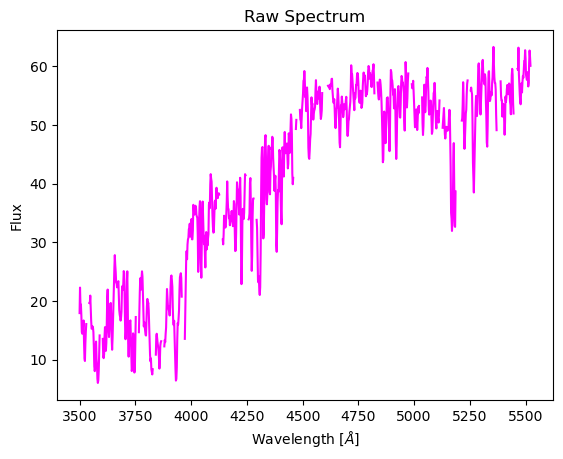

In [7]:
plt.title('Raw Spectrum')
plt.plot(wave_arr,nan_spec,color='magenta')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Flux')

In [8]:
# filling the nans
nan_indices = np.isnan(nan_spec)
x_len = np.arange(len(nan_spec))

# defining what will be interpolated
x = x_len[nan_indices]
xp = x_len[~nan_indices]
fp = nan_spec[~nan_indices]

interp_values = np.interp(x, xp, fp)
resampled_spec = nan_spec
resampled_spec[nan_indices] = interp_values

Text(0, 0.5, 'Flux')

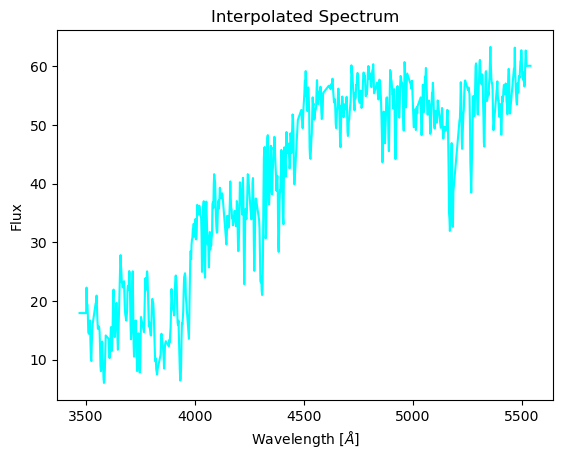

In [9]:
plt.title('Interpolated Spectrum')
plt.plot(wave_arr,resampled_spec,color='cyan')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Flux')

In [10]:
# creating general definition
def interpolation(spectrum):
    # defining masked indices as nans
    nan_spec = spectrum.filled(np.nan)
    
    # filling the nans
    nan_indices = np.isnan(nan_spec)

    # defining what will be interpolated
    x_len = np.arange(len(nan_spec))
    x = x_len[nan_indices]
    xp = x_len[~nan_indices]
    fp = nan_spec[~nan_indices]

    # interpolating
    interp_values = np.interp(x, xp, fp)
    resampled_spec = nan_spec
    resampled_spec[nan_indices] = interp_values

    return resampled_spec

## Continuum Normalizing

In [11]:
slice = 100
half_slice = slice//2
cont_arr = []

for i in range(half_slice, len(resampled_spec) + half_slice):
    sliced_spec = resampled_spec[i-half_slice:i+half_slice]
    cont = np.percentile(sliced_spec, 90)
    cont_arr.append(cont)
    slice = slice + 1

Text(0, 0.5, 'Flux')

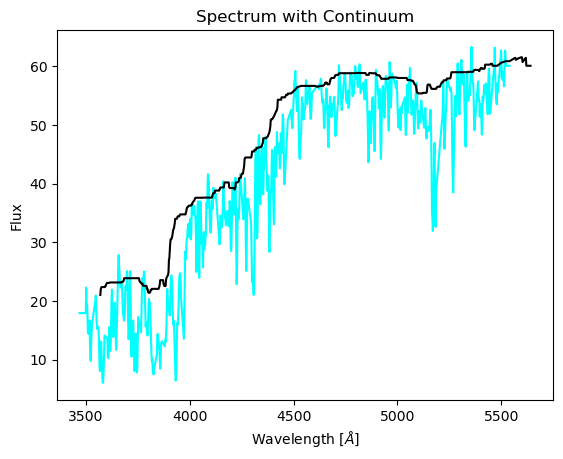

In [12]:
plt.title('Spectrum with Continuum')
plt.plot(wave_arr,resampled_spec,color='cyan')
plt.plot(wave_arr+100,cont_arr,color='black')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Flux')

In [13]:
# interpolating the first ~100 Ang of continuum, will cut off edges later
nan_arr = np.full(100, np.nan)
continuum = np.concatenate((nan_arr,cont_arr))

# filling the nans
nan_indices = np.isnan(continuum)
x_len = np.arange(len(continuum))

# defining what will be interpolated
x = x_len[nan_indices]
xp = x_len[~nan_indices]
fp = continuum[~nan_indices]

interp_values = np.interp(x, xp, fp)
continuum[nan_indices] = interp_values
continuum = continuum[:-100]

Text(0, 0.5, 'Flux')

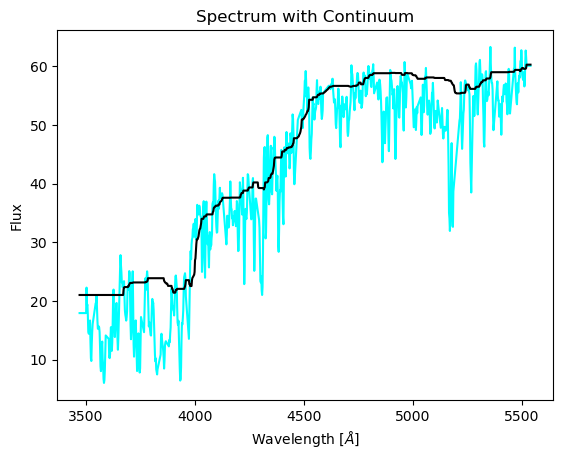

In [14]:
plt.title('Spectrum with Continuum')
plt.plot(wave_arr,resampled_spec,color='cyan')
plt.plot(wave_arr,continuum,color='black')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Flux')

In [15]:
normalized_spec = resampled_spec / continuum

Text(0, 0.5, 'Normalized Flux')

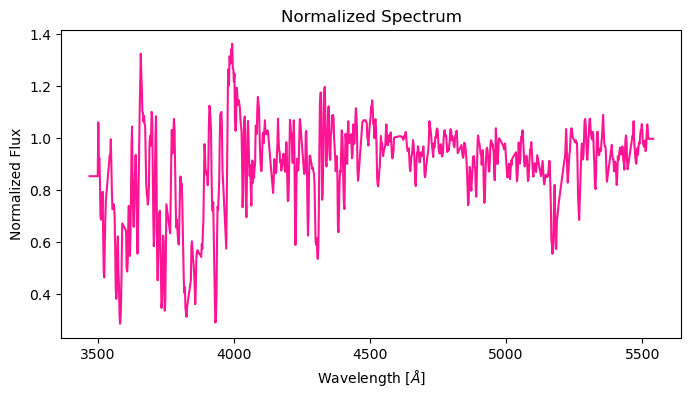

In [16]:
plt.figure(figsize=(8,4))
plt.title('Normalized Spectrum')
plt.plot(wave_arr,normalized_spec,color='deeppink')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Normalized Flux')

In [17]:
# creating general definition
def normalization(spectrum,percent):

    slice = 100
    half_slice = slice//2
    cont_arr = []

    for i in range(half_slice, len(spectrum) + half_slice):
        sliced_spec = spectrum[i-half_slice:i+half_slice]
        cont = np.percentile(sliced_spec, 90)
        cont_arr.append(cont)
        slice = slice + 1

    # interpolating the first ~100 Ang of continuum, will cut off edges later
    nan_arr = np.full(100, np.nan)
    continuum = np.concatenate((nan_arr,cont_arr))

    nan_indices = np.isnan(continuum)
    x_len = np.arange(len(continuum))

    x = x_len[nan_indices]
    xp = x_len[~nan_indices]
    fp = continuum[~nan_indices]

    interp_values = np.interp(x, xp, fp)
    continuum[nan_indices] = interp_values
    continuum = continuum[:-100]
    
    normalized_spec = spectrum / continuum
    
    return continuum,  normalized_spec

## Applying Interpolations and Normalizations to all Science Spectra

In [18]:
# making a generalized definition
def interp_norm(table,spec_array,percent):
    spec_l = []
    
    for i in range(len(table)):
        s = interpolation(table[spec_array][i])
        spec_l.append(s)

    table['smooth_spec'] = spec_l

    cont_l = []
    norm_l = []

    for i in range(len(table)):
        c , n = normalization(table['smooth_spec'][i],percent)
        cont_l.append(c)
        norm_l.append(n)

    table['continuum'] = cont_l
    table['normalized_spec'] = norm_l

In [19]:
interp_norm(hetvips_lamost,'spec',95)

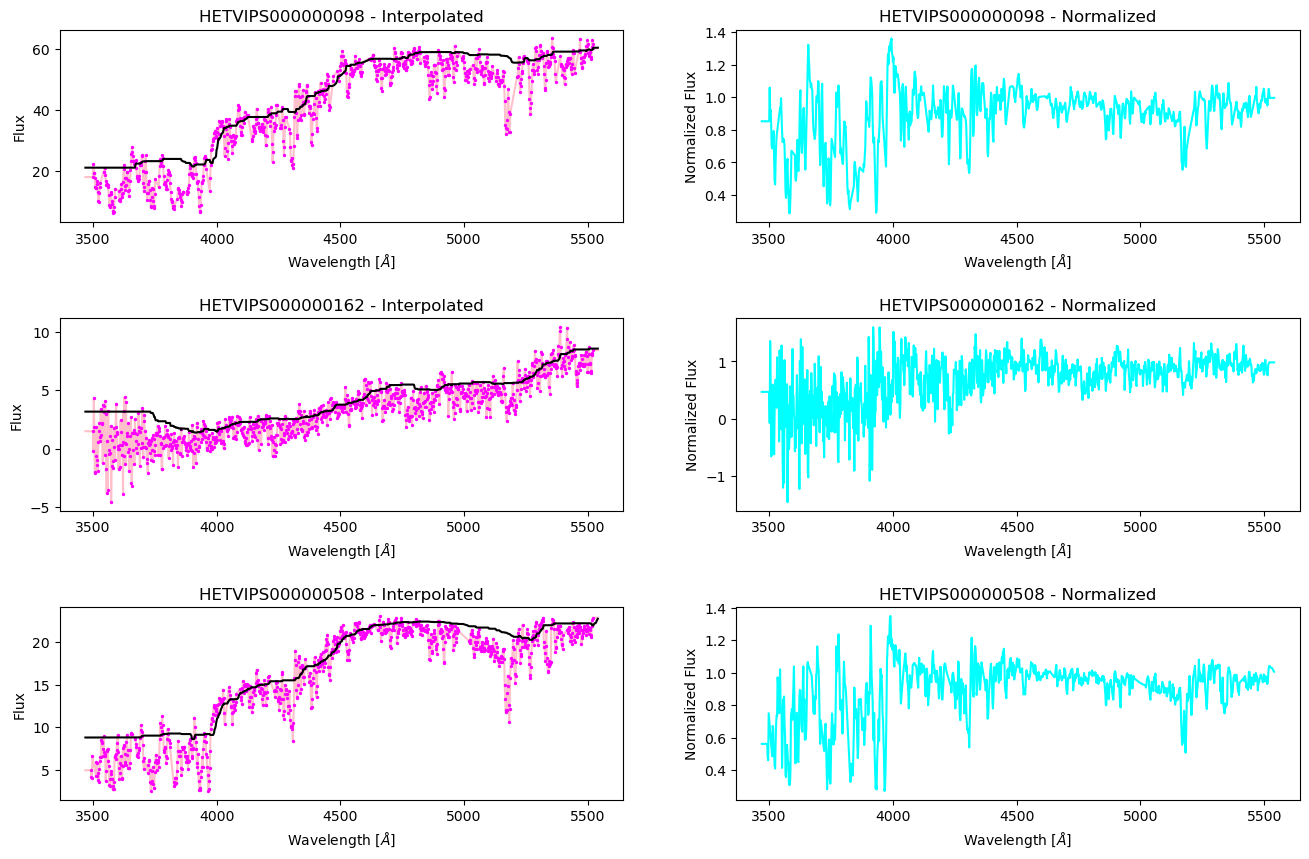

In [20]:
# plotting the first couple of spectra 
fig,ax = plt.subplots(3,2,dpi=100,figsize=(16,10), gridspec_kw={'hspace': 0.5, 'wspace': 0.2})
for i in range(0,3):
    ax[i][0].plot(wave_arr,hetvips_lamost['smooth_spec'][i],color='pink',zorder=1)
    ax[i][0].scatter(wave_arr,hetvips_lamost['spec'][i],s=2,color='magenta')
    ax[i][0].plot(wave_arr,hetvips_lamost['continuum'][i],color='black')
    ax[i][1].plot(wave_arr,hetvips_lamost['normalized_spec'][i],color='cyan')

    ax[i][1].set_title('%s - Normalized'%(hetvips_lamost['objID_1'][i]))
    ax[i][1].set_xlabel(r'Wavelength [$\AA$]')
    ax[i][1].set_ylabel('Normalized Flux')
    ax[i][0].set_title('%s - Interpolated'%(hetvips_lamost['objID_1'][i]))
    ax[i][0].set_xlabel(r'Wavelength [$\AA$]')
    ax[i][0].set_ylabel('Flux')

In [50]:
hetvips_lamost

objID_1,RA,Dec,shotid,gmag,rmag,imag,zmag,ymag,sn,barycor,mjd,exptime,chi2_star,chi2_galaxy,chi2_qso,z_star,z_galaxy,z_qso,z_best,classification,stellartype,ObjID_2,filename_1,index_in_file,spec,spec_error,spec_weight,RV_1,barycorr,SPECID_1,RA_1,DEC_1,SNR_U,SNR_G,SNR_R,SNR_I,SNR_Z,RV_2,RV_ERR,TEFF,TEFF_ERR,TEFF_FLAG,TEFF_GRADCORR,LOGG,LOGG_ERR,LOGG_FLAG,LOGG_GRADCORR,VMIC,VMIC_ERR,VMIC_FLAG,VMIC_GRADCORR,FEH,FEH_ERR,FEH_FLAG,FEH_GRADCORR,ALPHA_FE,ALPHA_FE_ERR,C_FE,C_FE_ERR,C_FE_FLAG,C_FE_GRADCORR,N_FE,N_FE_ERR,N_FE_FLAG,N_FE_GRADCORR,O_FE,O_FE_ERR,O_FE_FLAG,O_FE_GRADCORR,NA_FE,NA_FE_ERR,NA_FE_FLAG,NA_FE_GRADCORR,MG_FE,MG_FE_ERR,MG_FE_FLAG,MG_FE_GRADCORR,AL_FE,AL_FE_ERR,AL_FE_FLAG,AL_FE_GRADCORR,SI_FE,SI_FE_ERR,SI_FE_FLAG,SI_FE_GRADCORR,CA_FE,CA_FE_ERR,CA_FE_FLAG,CA_FE_GRADCORR,TI_FE,TI_FE_ERR,TI_FE_FLAG,TI_FE_GRADCORR,CR_FE,CR_FE_ERR,CR_FE_FLAG,CR_FE_GRADCORR,MN_FE,MN_FE_ERR,MN_FE_FLAG,MN_FE_GRADCORR,CO_FE,CO_FE_ERR,CO_FE_FLAG,CO_FE_GRADCORR,NI_FE,NI_FE_ERR,NI_FE_FLAG,NI_FE_GRADCORR,CU_FE,CU_FE_ERR,CU_FE_FLAG,CU_FE_GRADCORR,BA_FE,BA_FE_ERR,BA_FE_FLAG,BA_FE_GRADCORR,CHI2,CHI2RATIO,QFLAG_CHI2,CHI2_NA,CHI2RATIO_NA,QFLAG_CHI2NA,SNR_DPARALLAX,FLAG_SINGLESTAR,UQFLAG,STARID,SUBCLASS,FILENAME_2,specid_2,solution_id,designation,source_id,random_index,ref_epoch,ra_2,ra_error,dec_2,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,dist,Separation_2,Separation,smooth_spec,continuum,normalized_spec
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),'dex',deg,deg,deg,deg,,arcsec,arcsec,,,
bytes16,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,bytes1,bytes16,bytes58,int64,float64[1036],float64[1036],float64[1036],float64,float64,bytes36,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,flo

## Matching Template Spectra

In [21]:
# trying with one template first
template = Table.read('../RVgrid/T4000_g0.50_f-0.50.spec.conv',format='ascii',names=['wave','flux_n','flux_u'])

In [22]:
# defining what will be interpolated
x = wave_arr
xp = np.arange(len(template))
fp = template['flux_u']

# interp_temp = np.interp(x, xp, fp)
interp_temp = np.interp(x,template['wave'],template['flux_u'])
cont_temp, norm_temp = normalization(interp_temp,95)

Text(0, 0.5, 'Flux')

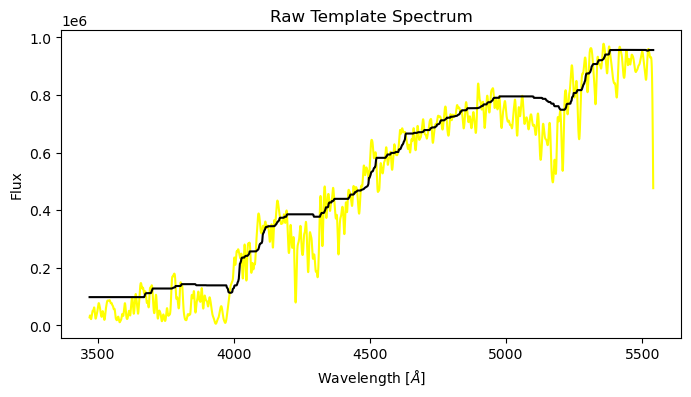

In [23]:
plt.figure(figsize=(8,4))
plt.title('Raw Template Spectrum')
plt.plot(template['wave'],template['flux_u'],color='yellow')
plt.plot(wave_arr,cont_temp,color='black')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Flux')

Text(0, 0.5, 'Normalized Flux')

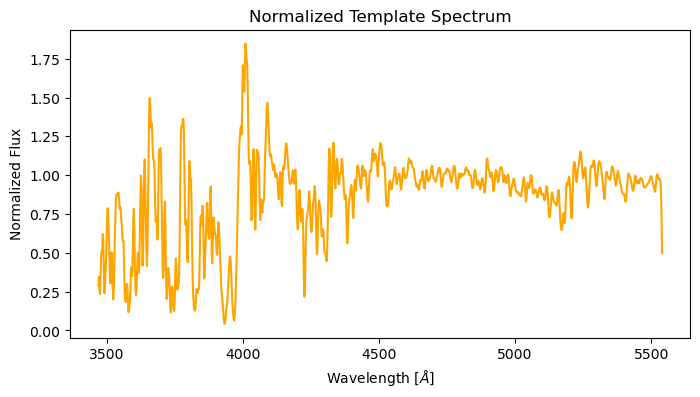

In [24]:
plt.figure(figsize=(8,4))
plt.title('Normalized Template Spectrum')
plt.plot(wave_arr,norm_temp,color='orange')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Normalized Flux')

In [26]:
# doing for all template spectra
filenames = glob.glob('../RVgrid/*.spec.conv')

In [27]:
filenames

['../RVgrid/T4250_g3.50_f0.50.spec.conv',
 '../RVgrid/T6250_g2.50_f0.00.spec.conv',
 '../RVgrid/T5750_g2.50_f-2.00.spec.conv',
 '../RVgrid/T4750_g2.50_f-1.50.spec.conv',
 '../RVgrid/T6250_g4.90_f-2.00.spec.conv',
 '../RVgrid/T6500_g3.50_f-1.50.spec.conv',
 '../RVgrid/T6250_g4.00_f0.00.spec.conv',
 '../RVgrid/T6250_g1.00_f-0.50.spec.conv',
 '../RVgrid/T6250_g2.00_f-1.00.spec.conv',
 '../RVgrid/T4000_g3.00_f-1.00.spec.conv',
 '../RVgrid/T4750_g4.00_f-0.50.spec.conv',
 '../RVgrid/T4500_g3.50_f0.50.spec.conv',
 '../RVgrid/T6500_g2.50_f0.00.spec.conv',
 '../RVgrid/T6500_g4.00_f0.00.spec.conv',
 '../RVgrid/T6500_g1.00_f-1.50.spec.conv',
 '../RVgrid/T4000_g2.50_f-0.50.spec.conv',
 '../RVgrid/T6250_g3.50_f-0.50.spec.conv',
 '../RVgrid/T4000_g1.00_f0.00.spec.conv',
 '../RVgrid/T6500_g4.50_f-1.00.spec.conv',
 '../RVgrid/T4000_g1.50_f-1.00.spec.conv',
 '../RVgrid/T4750_g1.00_f0.00.spec.conv',
 '../RVgrid/T4000_g4.00_f-1.50.spec.conv',
 '../RVgrid/T5000_g4.00_f-2.00.spec.conv',
 '../RVgrid/T4000_g

In [51]:
# doing for all template spectra
temp_names = []
raw_fluxes = []
continua = []
norm_fluxes = []

for i in range(len(filenames)):

    # naming the templates
    temp_name = filenames[i][10:27]
    temp_names.append(temp_name)

    # saving the raw fluxes to an array
    template = Table.read(filenames[i],format='ascii',names=['wave','flux_n','flux_u'])
    raw_fluxes.append(template['flux_u'])

    # interpolating and normalizing
    x = wave_arr
    xp = np.arange(len(template))
    fp = template['flux_u']
    interp_temp = np.interp(x,template['wave'],template['flux_u'])
    cont_temp, norm_temp = normalization(interp_temp,95)
    continua.append([cont_temp])
    norm_fluxes.append(norm_temp)

In [53]:
temp_table = Table([temp_names,raw_fluxes,continua,norm_fluxes],names=['temp_name','raw_flux','cont','norm_flux'])

In [54]:
temp_table

temp_name,raw_flux,cont,norm_flux
str17,float64[20701],"float64[1,1036]",float64[1036]
T4250_g3.50_f0.50,74662.9 .. 798880.0,242681.00000000006 .. 1603322.0,0.30765861357090163 .. 0.4982654763048221
T6250_g2.50_f0.00,3861610.0 .. 6653020.0,7707747.000000001 .. 13583860.0,0.5010037304026714 .. 0.48977389342940814
T5750_g2.50_f-2.0,2850770.0 .. 3992050.0,5692984.0 .. 8071949.0,0.5007514512600071 .. 0.49455837741293956
T4750_g2.50_f-1.5,726495.0 .. 1552010.0,1591086.0 .. 3051020.0,0.4566032257212998 .. 0.5086856198910529
T6250_g4.90_f-2.0,5870410.0 .. 5501420.0,11468980.0 .. 11254720.0,0.5118510974820777 .. 0.48881002814819025
T6500_g3.50_f-1.5,5765480.0 .. 6833860.0,11194120.0 .. 14071870.0,0.515045398834388 .. 0.48563979058931045
T6250_g4.00_f0.00,4938690.0 .. 6371840.0,9824887.0 .. 12965070.0,0.5026714302159404 .. 0.4914620592098616
T6250_g1.00_f-0.5,2828890.0 .. 6704500.0,5728451.0 .. 13703400.0,0.4938315785541327 .. 0.4892581403155421
T6250_g2.00_f-1.0,3671530.0 .. 6300850.0,7254306.0 .. 12889340.0,0.5061173322437735 .. 0.48884194225615896


## Computing Chi2
#### Chi2 equation is $\Sigma(F_{obs} - F_{temp})^2$ / $\sigma_{obs err}^2$

In [62]:
def chi_squared(f_obs):

    scores = []

    for this_template in temp_table:
        values = []
        for i in range(len(f_obs)):
            O = f_obs[i] 
            E = this_template['norm_flux'][i]

            value = (O - E)**2 / E
            values.append(value)

        chi2 = np.sum(values)

        scores.append([this_template['temp_name'],chi2])

    return scores

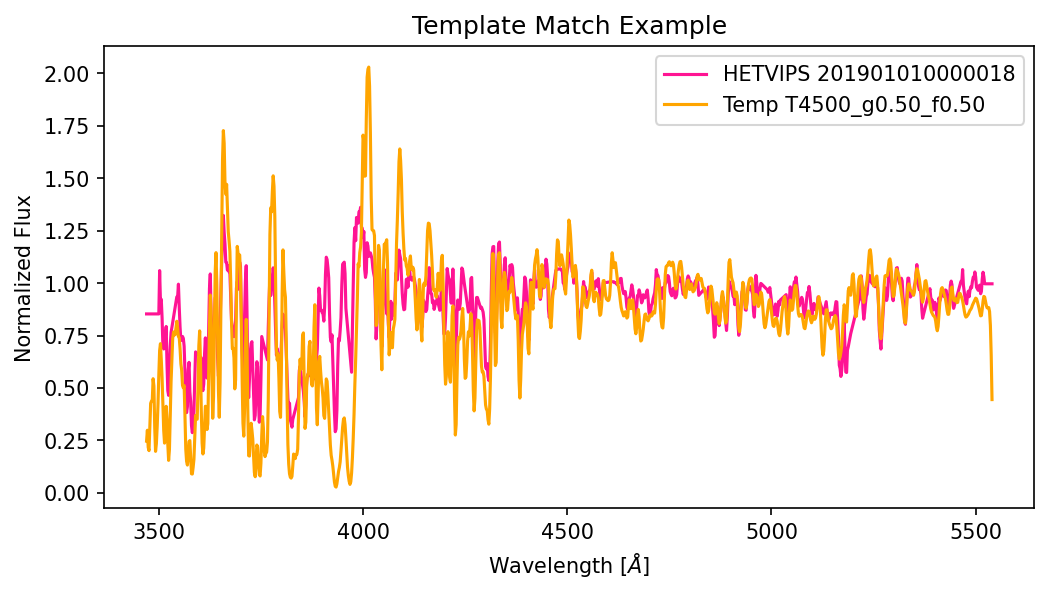

In [102]:
# testing with first spectrum
test = chi_squared(hetvips_lamost['normalized_spec'][0])
chis = [pair[1] for pair in test]
ind = np.where(chis == np.max(chis))[0]
name, test = test[ind[0]]

plt.figure(dpi=150,figsize=(8,4))
plt.title('Template Match Example')
plt.plot(wave_arr,hetvips_lamost['normalized_spec'][0],color='deeppink',label='HETVIPS %s'%(hetvips_lamost['shotid'][0]))

plt.plot(wave_arr,temp_table['norm_flux'][ind[0]],color='orange',label = 'Temp %s'%(name))

plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Normalized Flux')
plt.legend()

In [103]:
# doing for all spectra

final_scores = []

for i in range(len(hetvips_lamost)):
    score = chi_squared(hetvips_lamost['normalized_spec'][i])
    chis = [pair[1] for pair in score]
    ind = np.where(chis == np.max(chis))[0]

    final_scores.append(score[ind[0]])

In [106]:
hetvips_lamost['temp_matches'] = final_scores

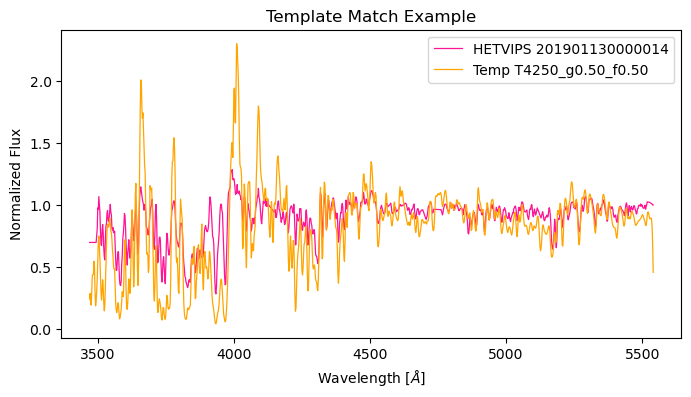

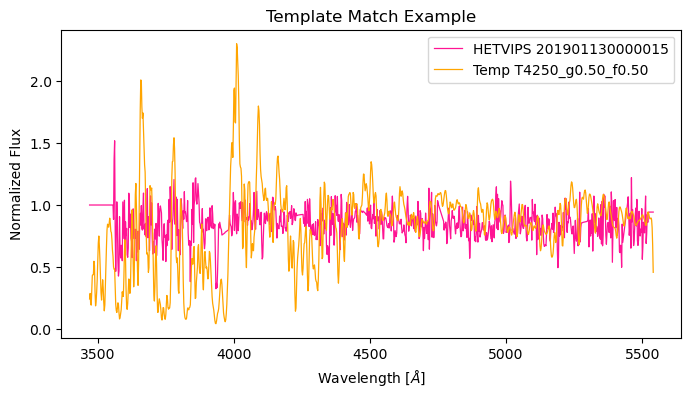

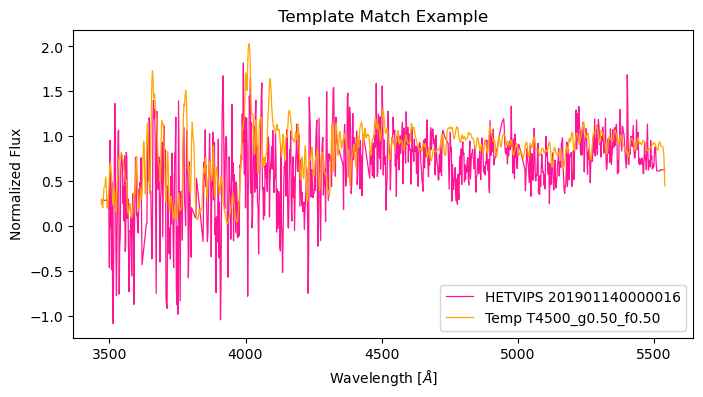

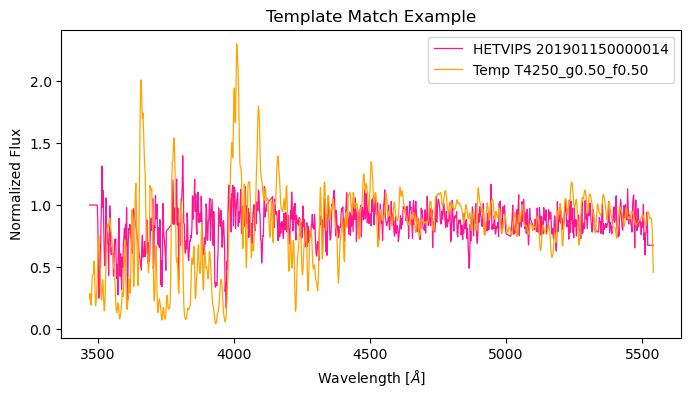

In [127]:
# plotting some examples
for i in range(21,25):
    plt.figure(dpi=100,figsize=(8,4))
    plt.title('Template Match Example')
    plt.plot(wave_arr,hetvips_lamost['normalized_spec'][i],color='deeppink',label='HETVIPS %s'%(hetvips_lamost['shotid'][i]),linewidth=0.9)

    match = hetvips_lamost['temp_matches'][i]
    ind = np.where(temp_table['temp_name'] == match[0])[0]
    plt.plot(wave_arr,temp_table['norm_flux'][ind[0]],color='orange',label = 'Temp %s'%(match[0]),linewidth=0.9)

    plt.xlabel(r'Wavelength [$\AA$]')
    plt.ylabel('Normalized Flux')
    plt.legend()

In [109]:
# saving table as a file so we don't have to re-run it each time
hetvips_lamost.write('hetvips_normalized_matched.fits')

## Radial Velocity Determination